## Create folders & Dataset v3 CSV

In [1]:
import os, pandas as pd

# 1) Create folders
os.makedirs("data", exist_ok=True)
os.makedirs("outputs", exist_ok=True)
os.makedirs("visuals", exist_ok=True)

# 2) Build Dataset v3 (matches the Medium section)
df = pd.DataFrame({
    'Hero': ['Genji','Hanzo','Mercy','Ana','Kiriko','Reinhardt','Zarya','Tracer'],
    'Mobility': [9,7,4,3,8,3,4,10],
    'Self_Sustain': [3,2,1,5,7,1,6,1],
    'Mechanical_Skill': [9,8,5,9,6,5,7,6],
    'HP': [200,200,200,200,200,550,475,150],
    'Damage': [1,1,0,0,0,0,0,1],
    'Support': [0,0,1,1,1,0,0,0],
    'Tank': [0,0,0,0,0,1,1,0]
})

df.to_csv("data/overwatch_hero_psychology.csv", index=False)
df  # show it

,Hero,Mobility,Self_Sustain,Mechanical_Skill,HP,Damage,Support,Tank
0,Genji,9,3,9,200,1,0,0
1,Hanzo,7,2,8,200,1,0,0
2,Mercy,4,1,5,200,0,1,0
3,Ana,3,5,9,200,0,1,0
4,Kiriko,8,7,6,200,0,1,0
5,Reinhardt,3,1,5,550,0,0,1
6,Zarya,4,6,7,475,0,0,1
7,Tracer,10,1,6,150,1,0,0


## Requirements helper 

In [2]:
open("requirements.txt","w").write(
"""pandas
numpy
scikit-learn
matplotlib
seaborn
"""
)
print("requirements.txt written")

requirements.txt written


## Load data, standardize features (z-score, Module 3 technique)

In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

df = pd.read_csv("data/overwatch_hero_psychology.csv")

num_features = ['Mobility', 'Self_Sustain', 'Mechanical_Skill', 'HP']
role_cols = ['Damage', 'Support', 'Tank']
all_features = num_features + role_cols

scaler = StandardScaler()
df_scaled = df.copy()
df_scaled[num_features] = scaler.fit_transform(df[num_features])

df_scaled

,Hero,Mobility,Self_Sustain,Mechanical_Skill,HP,Damage,Support,Tank
0,Genji,1.133893,-0.109764,1.383440,-0.509353,1,0,0
1,Hanzo,0.377964,-0.548821,0.732410,-0.509353,1,0,0
2,Mercy,-0.755929,-0.987878,-1.220683,-0.509353,0,1,0
3,Ana,-1.133893,0.768350,1.383440,-0.509353,0,1,0
4,Kiriko,0.755929,1.646464,-0.569652,-0.509353,0,1,0
5,Reinhardt,-1.133893,-0.987878,-1.220683,1.970976,0,0,1
6,Zarya,-0.755929,1.207407,0.081379,1.439477,0,0,1
7,Tracer,1.511858,-0.987878,-0.569652,-0.863686,1,0,0


## Cosine similarity matrix + save to CSV

In [6]:
from sklearn.metrics.pairwise import cosine_similarity

sim_matrix = cosine_similarity(df_scaled[all_features])
sim_df = pd.DataFrame(sim_matrix, index=df['Hero'], columns=df['Hero'])

sim_df.to_csv("outputs/similarity_matrix.csv", index=True)
sim_df

Hero,Genji,Hanzo,Mercy,Ana,Kiriko,Reinhardt,Zarya,Tracer
Hero,,,,,,,,
Genji,1.000000,0.872610,-0.496910,0.169062,0.031682,-0.622773,-0.336956,0.506807
Hanzo,0.872610,1.000000,-0.121889,0.125607,-0.234946,-0.405695,-0.479513,0.618155
Mercy,-0.496910,-0.121889,1.000000,-0.071103,-0.053170,0.380710,-0.310335,0.202303
Ana,0.169062,0.125607,-0.071103,1.000000,0.177382,-0.327995,0.229242,-0.543761
Kiriko,0.031682,-0.234946,-0.053170,0.177382,1.000000,-0.430710,0.127760,0.055121
Reinhardt,-0.622773,-0.405695,0.380710,-0.327995,-0.430710,1.000000,0.512235,-0.257194
Zarya,-0.336956,-0.479513,-0.310335,0.229242,0.127760,0.512235,1.000000,-0.694647
Tracer,0.506807,0.618155,0.202303,-0.543761,0.055121,-0.257194,-0.694647,1.000000


## Archetype centroids + rankings (Top N)

In [7]:
def centroid(hero_list):
    return df_scaled.set_index('Hero').loc[hero_list, all_features].mean().values

def rank_similar(query_vec, top_n=None):
    scores = cosine_similarity([query_vec], df_scaled[all_features])[0]
    ser = pd.Series(scores, index=df['Hero']).sort_values(ascending=False)
    return ser.head(top_n) if top_n else ser

# Queries (Module 3 "query entities")
solo_centroid      = centroid(['Genji','Hanzo'])
healer_centroid    = centroid(['Mercy','Ana','Kiriko'])
protector_centroid = centroid(['Reinhardt','Zarya'])

solo_rank      = rank_similar(solo_centroid)
healer_rank    = rank_similar(healer_centroid)
protector_rank = rank_similar(protector_centroid)

solo_rank, healer_rank, protector_rank

(Hero
 Genji        0.977918
 Hanzo        0.955415
 Tracer       0.570886
 Ana          0.155951
 Kiriko      -0.081378
 Mercy       -0.352556
 Zarya       -0.408881
 Reinhardt   -0.550082
 dtype: float64,
 Hero
 Kiriko       0.647880
 Ana          0.647016
 Mercy        0.466448
 Zarya        0.039915
 Hanzo       -0.126933
 Genji       -0.150714
 Tracer      -0.176867
 Reinhardt   -0.233246
 dtype: float64,
 Hero
 Reinhardt    0.903684
 Zarya        0.830656
 Mercy        0.092088
 Ana         -0.098344
 Kiriko      -0.215530
 Hanzo       -0.502084
 Tracer      -0.513072
 Genji       -0.571740
 dtype: float64)

## Export ranking tables (Markdown + CSV)

In [8]:
import os

def save_ranking(name, series):
    # CSV
    series.to_csv(f"outputs/{name}_ranking.csv", header=['similarity'])
    # Markdown
    lines = ["| Hero | Similarity Score |", "|------|------------------|"]
    for hero, score in series.items():
        lines.append(f"| **{hero}** | {score:.3f} |")
    with open(f"outputs/{name}_ranking.md", "w") as f:
        f.write("\n".join(lines))

save_ranking("solo_mastery", solo_rank)
save_ranking("healer_psyche", healer_rank)
save_ranking("protector_guardian", protector_rank)

# Also export Dataset v3 as a Markdown table (for Medium copy/paste)
with open("outputs/dataset_v3.md", "w") as f:
    f.write("| Hero | Mobility | Self-Sustain | Mechanical Skill | HP | Damage | Support | Tank |\n")
    f.write("|------|----------|--------------|------------------|----|--------|---------|------|\n")
    for _, r in df.iterrows():
        f.write(f"| **{r['Hero']}** | {int(r['Mobility'])} | {int(r['Self_Sustain'])} | {int(r['Mechanical_Skill'])} | {int(r['HP'])} | {int(r['Damage'])} | {int(r['Support'])} | {int(r['Tank'])} |\n")

print("Saved: outputs/*_ranking.(csv|md), outputs/dataset_v3.md")

Saved: outputs/*_ranking.(csv|md), outputs/dataset_v3.md


## Radar charts (matplotlib only)

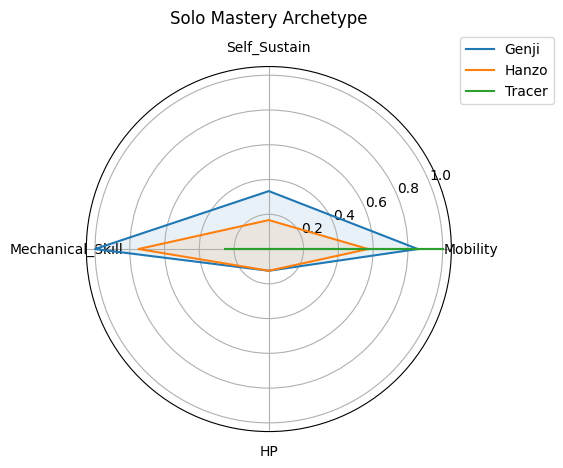

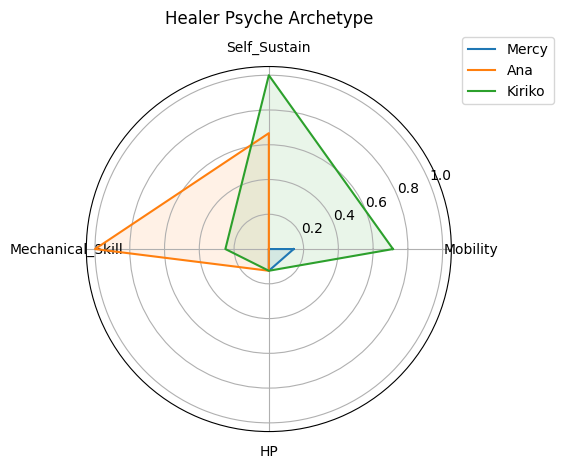

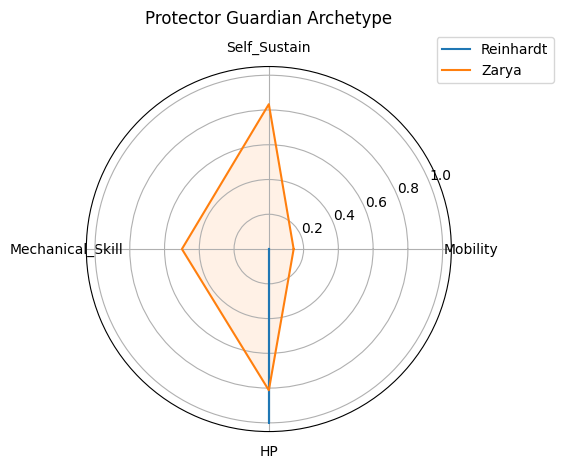

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Normalize 0–1 for plotting
min_vals = df[num_features].min()
max_vals = df[num_features].max()
df_norm = (df.set_index('Hero')[num_features] - min_vals) / (max_vals - min_vals)

def plot_radar(heroes, title, save_path=None):
    data = df_norm.loc[heroes]
    labels = data.columns.tolist()
    num_vars = len(labels)
    angles = np.linspace(0, 2*np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]

    fig, ax = plt.subplots(figsize=(6,6), subplot_kw=dict(polar=True))
    for hero in heroes:
        values = data.loc[hero].tolist()
        values += values[:1]
        ax.plot(angles, values, label=hero)
        ax.fill(angles, values, alpha=0.10)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels)
    ax.set_title(title, pad=12)
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
    fig.tight_layout()
    if save_path:
        fig.savefig(save_path, dpi=200)
    plt.show()

plot_radar(['Genji','Hanzo','Tracer'], 'Solo Mastery Archetype', 'visuals/radar_solo_mastery.png')
plot_radar(['Mercy','Ana','Kiriko'], 'Healer Psyche Archetype', 'visuals/radar_healer_psyche.png')
plot_radar(['Reinhardt','Zarya'], 'Protector Guardian Archetype', 'visuals/radar_protector_guardian.png')


## Heatmaps (seaborn) 

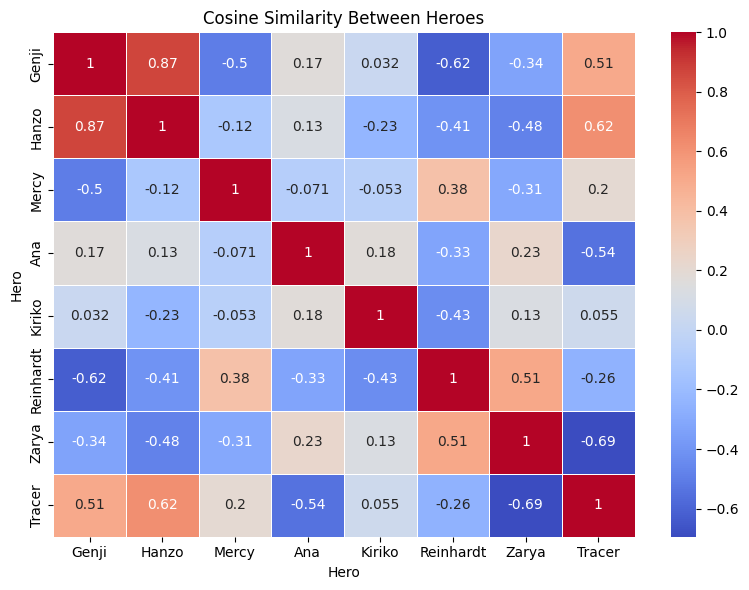

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
sns.heatmap(sim_df, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Cosine Similarity Between Heroes')
plt.tight_layout()
plt.savefig('visuals/similarity_heatmap.png', dpi=200)
plt.show()

## Quick copy helpers (print tables)

In [11]:
# Print markdown tables directly in output (so you can copy)
print(open("outputs/solo_mastery_ranking.md").read())
print()
print(open("outputs/healer_psyche_ranking.md").read())
print()
print(open("outputs/protector_guardian_ranking.md").read())
print()
print(open("outputs/dataset_v3.md").read())

| Hero | Similarity Score |
|------|------------------|
| **Genji** | 0.978 |
| **Hanzo** | 0.955 |
| **Tracer** | 0.571 |
| **Ana** | 0.156 |
| **Kiriko** | -0.081 |
| **Mercy** | -0.353 |
| **Zarya** | -0.409 |
| **Reinhardt** | -0.550 |

| Hero | Similarity Score |
|------|------------------|
| **Kiriko** | 0.648 |
| **Ana** | 0.647 |
| **Mercy** | 0.466 |
| **Zarya** | 0.040 |
| **Hanzo** | -0.127 |
| **Genji** | -0.151 |
| **Tracer** | -0.177 |
| **Reinhardt** | -0.233 |

| Hero | Similarity Score |
|------|------------------|
| **Reinhardt** | 0.904 |
| **Zarya** | 0.831 |
| **Mercy** | 0.092 |
| **Ana** | -0.098 |
| **Kiriko** | -0.216 |
| **Hanzo** | -0.502 |
| **Tracer** | -0.513 |
| **Genji** | -0.572 |

| Hero | Mobility | Self-Sustain | Mechanical Skill | HP | Damage | Support | Tank |
|------|----------|--------------|------------------|----|--------|---------|------|
| **Genji** | 9 | 3 | 9 | 200 | 1 | 0 | 0 |
| **Hanzo** | 7 | 2 | 8 | 200 | 1 | 0 | 0 |
| **Mercy** | 4 | 